In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy scipy pandas matplotlib numpy_ringbuffer sklearn

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')

In [2]:
# currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp', 'eos']
# pairs = [c + '_usd' for c in currencies if c != 'usd']
# volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

# def prep_data(file):
#     data = pickle.load(open(file, 'rb'))
#     dates = [x['date'] for x in data]
#     prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
#     volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
#     return {
#         'prices': pd.DataFrame(prices, index = dates),
#         'volumes': pd.DataFrame(volumes, index = dates)
#     }

# def reduce_data(data, resampling):
#     '''Averages prices, sums volumes'''
#     prices = data['prices'].resample(resampling).first().fillna(method='ffill')
#     volumes = data['volumes'].resample(resampling).sum().fillna(method='ffill')
#     return { 'prices': prices, 'volumes': volumes }

# def tail_data(data, n):
#     '''get the last n points of the given data'''
#     prices = data['prices'].tail(n)
#     volumes = data['volumes'].tail(n)
#     return { 'prices': prices, 'volumes': volumes }

# def viz_data(data):
#     '''Only plots prices for now'''
#     plt.plot(data['prices'] / data['prices'].mean() - 1)
#     plt.show()

# def find_gaps(data, freq):
#     idx_ref = pd.date_range(start=data.index[0], end=data.index[-1],freq=freq)
#     gaps = idx_ref[~idx_ref.isin(data.index)]
#     return gaps

# data = prep_data('data/data.p')
# data_min = reduce_data(prep_data('data/data-minute.p'), '1Min')
# data_5min = reduce_data(data_min, '5Min')
# data_15min = reduce_data(data_min, '15Min')
# viz_data(data_min)

In [3]:
data_min = pd.read_hdf('data/1min.h5')
data_15min = data_min.resample('15Min').first()
data_1h = data_min.resample('1h').first()

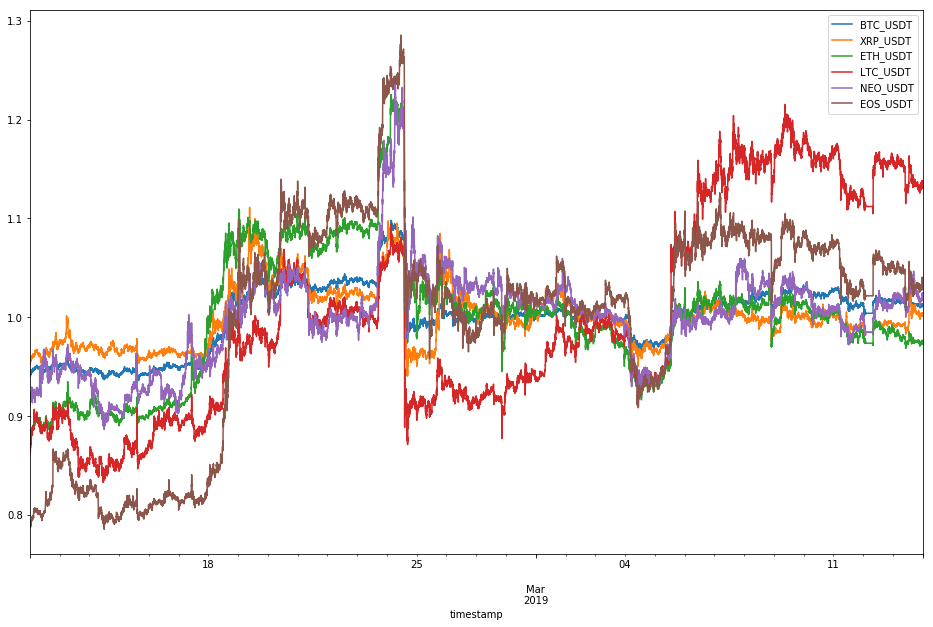

In [4]:
price_data = data_min.apply(lambda x: x['price'])
(price_data / price_data.mean()).plot(figsize=(16,10))

In [5]:
# def plot_matrix(df,size=10):
#     '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

#     Input:
#         df: pandas DataFrame
#         size: vertical and horizontal size of the plot'''

#     fig, ax = plt.subplots(figsize=(size, size))
#     ax.matshow(df)
#     plt.xticks(range(len(df.columns)), df.columns);
#     plt.yticks(range(len(df.index)), df.index);
#     # Loop over data dimensions and create text annotations.
#     for i in range(len(df.index)):
#         for j in range(len(df.columns)):
#             ax.text(j, i, '{:0.2f}'.format(df.iloc[i, j]), ha="center", va="center", color="w")

# plot_matrix(data_15min['prices'].corr())

In [6]:
# def cross_correlate_(x, y):
#     return np.argmax(np.correlate(x, y, mode='full')) - len(x) + 1

# def cross_correlate(df):
#     '''Compute cross-correlation matrix for the given dataframe.'''
#     ccs = pd.DataFrame(index=df.columns, columns=df.columns)
#     for i in df.columns:
#         for j in df.columns:
#             if i == j:
#                 ccs.loc[i,j] = 0
#                 continue
#             if np.isnan(ccs.loc[i,j]):
#                 ccs.loc[i,j] = cross_correlate_(df[i], df[j])
#                 ccs.loc[j,i] = -ccs.loc[i,j]
#     return ccs

# print(cross_correlate(pd.DataFrame([[1,2],[2,1],[1,2],[2,1],[1,2]])))
# print(cross_correlate(pd.DataFrame([[1,1],[2,2],[3,3],[4,4],[5,5]])))
    
# print(cross_correlate(data_min['prices']))

In [7]:
##### import numpy as np
import pandas as pd
from trader.util.stats import Gaussian

# Note: Assumes all orders fill at last trade price. Attempting to simulate market-making would
# require combing through book and trade data, which is too much work for us to do at the moment.

def data_currencies(data):
    quote_currency = data.iloc[0].index[0].partition("_")[2]
    currencies = [quote_currency]
    for pair in data.iloc[0].index:
        currencies.append(pair.partition('_')[0])
    return currencies

def to_usd(fairs, x):
    "pairs in x may be any XXX_YYY, so long as YYY_USD is also in fairs."

def get_orders(balances, prices, fairs, size, fees, min_edge):
    '''Given current balances, prices, and fair estimates, determine which orders to place.
    Assumes all pairs are XXX_USD.
    `fairs` should be a Gaussian type. '''
    quote_currency = prices.index[0].partition("_")[2]
    
    gradient = fairs.gradient(prices) * fairs.mean
#     gradient = fairs.mean / prices - 1
    balance_direction_vector = gradient / (np.linalg.norm(gradient) + 1e-100)
    target_balance_values = balance_direction_vector * fairs.z_score(prices) * size
    pair_balances = balances.drop([quote_currency]).rename(lambda c: '{}_{}'.format(c, quote_currency))
    proposed_orders = target_balance_values / prices - pair_balances
    profitable = np.sign(proposed_orders) * (fairs.mean / prices - 1) > fees + min_edge
    profitable_orders = proposed_orders * profitable
    
#     unprofitable_balance = pair_balances * edge.mean < 0
#     # TODO: in the near future we should model this via the cdf of the profitable order cutoff
#     p_reversion = 0.6
#     profitability_gross_edge_cutoff = fees + edge.stddev * min_edge
#     positive_ev_from_closing_position = p_reversion * (gross_edge.mean - fees) > (1-p_reversion) * (profitability_gross_edge_cutoff - fees)
#     balance_closing_orders = -pair_balances * unprofitable_balance * positive_ev_from_closing_position

    return profitable_orders # + balance_closing_orders


def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        currency, quote_currency = pair.split("_")
        value = size * prices[pair]
        balances[quote_currency] -= value
        balances[quote_currency] -= abs(value) * fees
        balances[currency] += size
        
class Preprocessor:
    def __init__(self, f, state_0):
        self.f = f
        self.state = state_0
        
    def step(self, frame):
        (state_new, processed_frame) = f(self.state, frame)
        self.state = state_new
        return processed_frame
    
null_preprocessor = Preprocessor(lambda _, frame: (None, frame), None)

def run(strategy, data, preprocessor = null_preprocessor, size=1000, fees=0, min_edge = 0):
    balances = pd.Series(dict.fromkeys(data_currencies(data), 0.))
    balances_ = []
    fairs_ = []
    for frame in data:
        processed_frame = preprocessor.step(frame)
        fairs = strategy.step(processed_frame)
        
        orders = get_orders(balances, frame['price'], fairs, size, fees, min_edge)
        execute_orders(fees, frame['price'], balances, orders)

        fairs_.append(fairs)
        balances_.append(balances.copy())
    return {
        'data': data,
        'fairs': pd.DataFrame(fairs_, index=data.index),
        'balances': pd.DataFrame(balances_, index=data.index)
    }


In [8]:
from strategy import HoldStrategy
from execution import analyze

analyze(run(HoldStrategy(), data_min.tail(50)))

NameError: name 'f' is not defined

In [ ]:
##### from strategy import Strategy
from trader.util.stats import Ema, Gaussian
from execution import analyze

import numpy as np
import pandas as pd
from numpy_ringbuffer import RingBuffer
from statsmodels.tsa.stattools import coint

# taken from coinmarketcap
MARKET_CAPS = pd.Series({ "BTC": 99e9, "ETH": 18e9, "XRP":14e9, "BCH": 5e9, "EOS": 5e9, "LTC": 5e9, "NEO": 7e8 })

def add_cap_weighted_fund(P, V, name, currencies):
    """
    Calculates a cap-weighted fund of currencies.
    Assumes all inputs are already normalized to the same quote currency.
    """
    P_components = pd.DataFrame(index=P.index)
    V_components = pd.DataFrame(index=V.index)
    for c in currencies:
        P_c = P.filter(regex = c+"_.*") # there may be multiple pairs for this base currency
        V_c = V.filter(regex = c+"_.*")
        V_components[c] = V_c.sum(axis=1)
        P_components[c] = (P_c * V_c).sum(axis=1) / V_components[c]
    P_components.fillna(method='ffill') # avg price will be NaN if volume is 0
    P_components.fillna(method='bfill') # if the first few entries are NaN, backfill. This seems suboptimal
    base_prices = P_components.mean()
    caps = MARKET_CAPS[currencies]
    ratios = 1 / base_prices * caps.values
    P[name] = P_components @ ratios / ratios.sum()
    V[name] = (V_components * P_components).sum(axis=1) / P[name]
    

# def add_cap_weighted_fund(P, volumes, name, pairs):
#     P_components = P[pairs]
#     base_prices = P_components.mean()
#     currencies = [pair[:3] for pair in pairs]
#     caps = MARKET_CAPS[currencies]
#     ratios = 1 / base_prices * caps.values
#     P[name] = P_components @ ratios / ratios.sum()
#     volumes[name] = volumes[pairs] @ base_prices / P[name].iloc[-1]

class KalmanFilter(Strategy):
    '''
    Models fairs based on correlated movements between pairs. Weights predictions by volume and
    likelihood of cointegration.
    '''

    def __init__(self, window_size, movement_half_life, cointegration_period, maxlag):
        self.price_history = None
        self.volume_history = None
        self.window_size = window_size
        self.movement_half_life = movement_half_life
        self.moving_prices = Ema(movement_half_life)
        self.moving_volumes = Ema(window_size / 2)
        self.cointegration_period = cointegration_period
        self.maxlag = maxlag
        self.prev_fair = None
        self.sample_counter = 0
        self.coint_f = None

    def step(self, frame):
        if self.price_history is None:
            self.price_history = RingBuffer(
                self.window_size, dtype=(np.float64, len(frame.index)))
            self.volume_history = RingBuffer(
                self.window_size, dtype=(np.float64, len(frame.index)))

        self.price_history.append(frame['price'])
        self.volume_history.append(frame['volume'])

        df = pd.DataFrame(self.price_history, columns=frame.index)
        df_volume = pd.DataFrame(self.volume_history, columns=frame.index)
#         add_cap_weighted_fund(df, volumes, "total_market", frame.index)
        add_cap_weighted_fund(df, df_volume, "total_market", [pair[:3] for pair in frame.index])
        prices = df.iloc[-1]
        volumes = df_volume.iloc[-1]
#         print(prices)
#         print(volumes)
        # the fair combination step assumes that all estimates are i.i.d. They are not (and obviously not in the case
        # of funds). Is this a problem?

        self.moving_prices.step(prices)
        self.moving_volumes.step(volumes)

        if len(self.price_history) < self.window_size or not self.moving_prices.ready:
            return self.null_estimate(frame['price'])

        if self.prev_fair is None:
            self.prev_fair = self.null_estimate(df.iloc[-1])
            
        if self.coint_f is None:
            self.coint_f = pd.DataFrame(1, index=df.columns, columns=df.columns)

        # calculate p values for pair cointegration
        if self.sample_counter == 0:
            deltas = df - df.mean()
            for i in df.columns:
                for j in df.columns:
                    if i >= j:
                        continue
                    p = coint(deltas[i], deltas[j], trend='nc', maxlag=self.maxlag, autolag=None)[1]
                    f = max(1, p * p * 2500)
                    self.coint_f.loc[i,j] = f
                    self.coint_f.loc[j,i] = f
#             print(self.coint_f)
        self.sample_counter = (self.sample_counter - 1) % self.cointegration_period
        
        diffs = df.diff()
        var = df.var()
        stddev = np.sqrt(var) + 1e-100
        r = df.corr()
        r2 = r * r
        correlated_slopes = r.mul(stddev, axis=1).div(stddev, axis=0)
        price_ratios = prices[np.newaxis, :] / prices[:, np.newaxis]
        delta = prices - self.moving_prices.value
        # In theory it's better to substitute self.prev_fair.mean for prices
        # in these calculations, but the difference is marginal and prices is more concise
        volume_signals = np.sqrt(self.moving_volumes.value * prices)
        volume_f = np.max(volume_signals) / volume_signals
        fair_delta_means = correlated_slopes.mul(delta, axis=0)
        delta_vars = diffs.rolling(self.movement_half_life).sum()[self.movement_half_life:].var()
        correlated_delta_vars = delta_vars[:, np.newaxis] * np.square(price_ratios)
        fair_delta_vars = volume_f * self.coint_f * ((1-r2) * delta_vars[np.newaxis, :] + r2 * correlated_delta_vars)
        fair_delta = Gaussian.intersect(
            [Gaussian(fair_delta_means.loc[i], fair_delta_vars.loc[i]) for i in df.columns])
        absolute_fair = fair_delta + self.moving_prices.value

        step = prices - self.prev_fair.mean
        fair_step_means = correlated_slopes.mul(step, axis=0)
        step_vars = diffs.var()
        correlated_step_vars = step_vars[:, np.newaxis] * np.square(price_ratios)
        fair_step_vars = volume_f * self.coint_f * ((1-r2) * step_vars[np.newaxis, :] + r2 * correlated_step_vars)
        fair_step =  Gaussian.intersect(
            [Gaussian(fair_step_means.loc[i], fair_step_vars.loc[i]) for i in df.columns])
        relative_fair = fair_step + self.prev_fair
        
        fair = absolute_fair & relative_fair
#         print("\n\nASDSA")
#         print(prices)
#         print(absolute_fair)
#         print(relative_fair)
#         print(fair)
        self.prev_fair = fair
        return fair[frame.index]

analyze(run(KalmanFilter(window_size = 500, movement_half_life = 4, cointegration_period=32, maxlag = 8), data_15min, fees=0.00075, min_edge=0.0005))

In [ ]:
import numpy as np
import pandas as pd
from numpy_ringbuffer import RingBuffer
import pickle

from research.strategy.base import Strategy
from trader.util.stats import Ema, Gaussian
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from trader.util.linalg import orthogonal_projection, hyperplane_projection
from statsmodels.tsa.stattools import adfuller
from scipy.spatial import distance

def johansen(P, maxlag):
    mean = P.mean()
    c = coint_johansen(P / mean - 1, det_order=-1, k_ar_diff=maxlag)
    significant_results = (c.lr1 > c.cvt[:,1]) * (c.lr2 < c.cvm[:,2])
    Q = pd.DataFrame(c.evec[:,significant_results].T, columns=P.columns)
    return mean, Q.div(Q.apply(np.linalg.norm, axis=1), axis=0)

# TODO: reimplement with vector autoregression test, similar to johansen internals.
def test_coint(P, mean_train, q, maxlag):
    x = (P / mean_train - 1) @ q
    return adfuller(x, regression="nc", maxlag=maxlag, autolag=None)[1]

def cosine_similar_to_any(Q, x):
    for q in Q:
        if distance.cosine(q, x) < 0.1:
            return True
    return False

class LiveCointegrator(Strategy):
    def __init__(self, train_size, validation_size, cointegration_period, maxlag):
        self.window_size = train_size + validation_size
        self.train_size = train_size
        self.validation_size = validation_size
        self.cointegration_period = cointegration_period
        self.maxlag = maxlag
        self.sample_counter = 0
        self.price_history = None
        self.Q = None
        self.base_prices = None
#         self.covs = None
        self.base_cov = None
        self.prev_fair = None
        self.coints = []

    def step(self, frame):
        prices = frame["price"]
        
        if self.price_history is None:
            self.price_history = RingBuffer(self.window_size, dtype=(np.float64, len(prices.index)))
            
        if self.prev_fair is None:
            self.prev_fair = self.null_estimate(prices)
            
        self.price_history.append(prices)
        
        if len(self.price_history) < self.window_size:
            return self.null_estimate(prices)
        
        if self.sample_counter == 0:
            P = pd.DataFrame(self.price_history, columns=prices.index)
            P_train = P.iloc[:self.train_size]
            P_val = P.iloc[self.train_size:]
            mean, candidates = johansen(P_train, self.maxlag)
            self.base_prices = mean
            new_coints = [q for q in candidates.values if test_coint(P_val, mean, q, self.maxlag) < .05]
            old_coints = [q for q in self.coints if test_coint(P_val, mean, q, self.maxlag) < .05 and not cosine_similar_to_any(new_coints, q)]
            self.coints = new_coints + old_coints
            self.base_cov = (P / P.mean()).cov()
            
        self.sample_counter -= 1
        self.sample_counter %= self.cointegration_period
        
        if not self.coints:
            return self.null_estimate(prices)
        
        fair_means = [hyperplane_projection(prices / self.base_prices - 1, q) for q in self.coints]
        fair = Gaussian.intersect([(Gaussian(mean, self.base_cov) + 1) * self.base_prices for mean in fair_means])
        
#         step_fair_means = [hyperplane_projection(prices / self.prev_fair.mean - 1, q) for q in self.coints]
#         step_fair = Gaussian.intersect([Gaussian(mean, self.base_cov) * self.prev_fair.mean for mean in step_fair_means])
        
#         fair = fair & (self.prev_fair + step_fair)
        self.prev_fair = fair
        return fair

analyze(run(LiveCointegrator(train_size=500, validation_size = 100, cointegration_period=64, maxlag=8), data_15min, fees=0.001, min_edge=0))

In [ ]:
import numpy as np
import pandas as pd
from numpy_ringbuffer import RingBuffer
import pickle

from research.strategy.base import Strategy
from trader.util.stats import Ema, Gaussian
from trader.util.linalg import orthogonal_projection, hyperplane_projection
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS

def plot_gaussian(x, y, gaussian):
    z = gaussian.pdf(np.dstack(np.meshgrid(x,y)))
    plt.pcolormesh(x, y, z)
    plt.show()

class LivePairCointegrator(Strategy):
    def __init__(self, window_size, cointegration_frequency=4):
        self.window_size = window_size
        self.cointegration_period = window_size // cointegration_frequency
        self.sample_counter = 0
        self.price_history = None
        self.prediction_covs = {}

    def step(self, frame):
        prices = frame["price"]
        
        if self.price_history is None:
            self.price_history = RingBuffer(self.window_size, dtype=(np.float64, len(prices.index)))
            
        self.price_history.append(prices)
        
        if len(self.price_history) < self.window_size:
            return self.null_estimate(prices)
        
        df = pd.DataFrame(self.price_history, columns=prices.index)
        self.mean = df.mean()
        deltas = df / self.mean - 1
        stddev = deltas.std() + 1e-100
        regression_slope = deltas.corr().mul(stddev, axis=1).div(stddev, axis=0)
        cov = deltas.cov()
        
        if self.sample_counter == 0:
            
            for pair_i in prices.index:
                for pair_j in prices.index:
                    if pair_i >= pair_j:
                        continue
                    deltas_ij = deltas[[pair_i, pair_j]]
                    regression_vector = [regression_slope.loc[pair_i][pair_j], -1]
                    residuals = orthogonal_projection(deltas_ij, regression_vector)
                    cov_resid = residuals.cov()
                    cov_pred = (deltas_ij - residuals).cov()
                    print(cov_pred)
                    # We can calculate the cointegration p-value more efficiently by reusing
                    # the residuals found via the orthogonal projection but getting it right is
                    # tricky. So we just do it the dumb way
                    p = coint(deltas[pair_j], deltas[pair_i], trend='nc', maxlag=0, autolag=None)[1]
#                     # regularize prediction covariance by using the raw price covariance shape with the 
#                     # prediction covariance slope
#                     cov_sam = deltas_ij.cov()
#                     w_pred, v_pred = np.linalg.eigh(cov_pred)
#                     w_sam, v_sam = np.linalg.eigh(cov_sam)
#                     eigenvalue_ratio_sam = w_sam[1] / w_sam[0]
#                     w_reg = w_pred[1] * np.array([eigenvalue_ratio_sam, 1])
#                     cov_reg = v_pred @ np.diag(w_reg) @ v_pred.T
#                     # discount predictions based on p-value
#                     cov_reg *= max(1, p * p * 900) # min(1e4, np.cosh(16 * p))
#                     cov_reg = pd.DataFrame(cov_reg, index=deltas_ij.columns, columns=deltas_ij.columns)
                    cov_reg = cov_pred + max(1, p * p * 900) * cov_resid
                    self.prediction_covs[pair_i, pair_j] = cov_reg
                    self.prediction_covs[pair_j, pair_i] = cov_reg.loc[::-1, ::-1]
                    
                    # uncomment and run this if you want to see what the prediction covariances look like
                    
                    prediction = Gaussian(pd.Series(0, index=deltas_ij.columns), cov_resid)
                    base = Gaussian(pd.Series(0, index=deltas_ij.columns),  cov_pred)
                    regularized = Gaussian(pd.Series(0, index=deltas_ij.columns), cov_reg)
                    xrange = deltas[pair_i].max() - deltas[pair_i].min()
                    yrange = deltas[pair_j].max() - deltas[pair_j].min()
                    x = np.linspace(-xrange, xrange)
                    y = np.linspace(-yrange, yrange)
                    plot_gaussian(x, y, prediction)
                    plot_gaussian(x, y, base)
                    plot_gaussian(x, y, regularized)
            
        self.sample_counter -= 1
        self.sample_counter %= self.cointegration_period
        
        fairs = []
        delta = prices / self.mean - 1
        cov = deltas.cov()
        for pair_i in prices.index:
            for pair_j in prices.index:
                if pair_i >= pair_j:
                    continue
                regression_vector = [regression_slope.loc[pair_i][pair_j], -1]
#                 residuals = orthogonal_projection(deltas[[pair_i, pair_j]], regression_vector)
                fair_delta_mean = hyperplane_projection(delta[[pair_i, pair_j]], regression_vector)
                fair_cov = self.prediction_covs[pair_i, pair_j]
                fair = Gaussian(fair_delta_mean, fair_cov)
#                 fair = Gaussian(fair_delta_mean, cov.loc[[pair_i, pair_j], [pair_i, pair_j]])
#                 scale = fair.z_score(delta[[pair_i, pair_j]])
#                 fair = Gaussian(fair.mean, fair.covariance * scale)
#                 print(prices)
#                 print(fair)
#                 x = np.linspace(deltas[pair_i].min(), deltas[pair_i].max()) - deltas[pair_i].mean()
#                 y = np.linspace(deltas[pair_j].min(), deltas[pair_j].max()) - deltas[pair_j].mean()
#                 plot_gaussian(x, y, fair)
#                 plot_gaussian(x, y, Gaussian(pd.Series(0, index=[pair_i, pair_j]), residuals.cov()))
#                 plot_gaussian(x, y, Gaussian(pd.Series(0, index=[pair_i, pair_j]), deltas[[pair_i, pair_j]].cov()))
                fairs.append(fair)
#         print(fairs)
        fair = (Gaussian.intersect(fairs) + 1) * self.mean
#         print(prices)
#         print(fair)
#         x = np.linspace(df['BTC_USDT'].min(), df['BTC_USDT'].max())
#         y = np.linspace(df['ETH_USDT'].min(), df['ETH_USDT'].max())
#         plot_gaussian(x, y, fair[['BTC_USDT', 'ETH_USDT']])
#         print(fair / prices - 1)
        return fair

analyze(run(LivePairCointegrator(window_size=96), data_15min.tail(1500), fees=0.001, min_edge=0))

In [ ]:
analyze(run(CointegratorStrategy(cointegration_window_size = 16), data_15min))

In [ ]:
analyze(run(KalmanFilterStrategy(
    correlation_window_size = 480,
    movement_half_life = 1
), tail_data(data_min, 10000), fees = 0.002))

In [ ]:
from strategy import CombinedStrategy

analyze(run(CombinedStrategy([
    KalmanFilterStrategy(correlation_window_size = 60, movement_half_life = 3),
    CointegratorStrategy(cointegration_window_size = 16)
]), data_15min))

In [ ]:
analyze(run(CointegratorStrategy(cointegration_window_size = 512), data_5min))

In [ ]:
analyze(run(KalmanFilterStrategy(correlation_window_size = 165, movement_half_life = 70), data_5min))

In [ ]:
analyze(run(CombinedStrategy([
    KalmanFilterStrategy(correlation_window_size = 16, movement_half_life = 8),
    CointegratorStrategy(cointegration_window_size = 64)
]), tail_data(data_min, 1500)))

In [ ]:
import random

def find_best_window_sizes(data, n):
    points = []
    best = None
    best_ror = 0
    for _ in range(n):
        movement_half_life = random.expovariate(1) * 15
#         window_ratio = random.uniform(1, 10)
#         window_size = max(3, int(movement_half_life * window_ratio))
#         movement_half_life = 2
        window_size = int(random.expovariate(1) * 100) + 400
#         window_size = int(random.expovariate(1) * 30) + 3
#         window_size = 4
#         window_size = 32
        print('Trying window_size: {0} and half_life: {1}'.format(window_size, movement_half_life))
        ror = analyze(run(KalmanFilter(window_size, movement_half_life), data, fees = 0.002), plot=False)
        print('  RoR: {0}'.format(ror))
        point = { 'window_size': window_size, 'half_life': movement_half_life, 'RoR': ror }
        points.append(point)
        if ror > best_ror:
            best = point
            best_ror = ror
    print('Best found:')
    print(best)
    pd.DataFrame(points).plot.scatter('window_size', 'half_life', c='RoR', colormap='jet')
    
find_best_window_sizes(tail_data(data_min, 1500), 25)